In [1]:
# First we grab the model and the unembedding weight matrix
import torch
from easy_transformer import EasyTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

unembed = model.unembed.W_U.data
unembed_bias = model.unembed.b_U.data
d_model = model.cfg.d_model
d_vocab = model.cfg.d_vocab

/home/giles/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
Loading model: gpt2


Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu


In [2]:
    
# Convenience function for decoding token
decode = model.tokenizer.decode

def decode_pad(t):
    string = decode(t)
    return f'{string:10}'

# Turn the embedding vector into a set of token probabilities
def embed_vector_to_probs(v):
    if v.shape != (d_model,):
        raise Exception(f"Shape should be [{d_model}], got {v.shape}")
    logits = torch.matmul(v.to(device), unembed)
    return torch.nn.functional.softmax(logits, dim=0)

# A function for understanding a vector in embedding space
def print_embed_vector(v):
    if v.shape != (d_model,):
        raise Exception(f"Shape should be [{d_model}], got {v.shape}")
    logits = torch.matmul(v.to(device), unembed)
    probs = torch.nn.functional.softmax(logits, dim=0)
    values = [(v.item(),i) for i,v in enumerate(logits)]
    values.sort(reverse=True)
    for i in range(10):
        j = values[i][1]
        print(f'{decode_pad(j)} {values[i][0]} {probs[j]}')
    print('  ...')
    for i in range(d_vocab-5,d_vocab):
        j = values[i][1]
        print(f'{decode_pad(j)} {values[i][0]} {probs[j]}')


In [3]:
# Choose some tokens ("common" according to the bias vector, but not too common because those are mostly boring stop words)
values = [(v.item(), i) for i,v in enumerate(unembed_bias)]
values.sort(reverse=True)
chosen_tokens = [i for v,i in values[500:600]]
print(list(decode(t) for t in chosen_tokens))

['5', ' men', '4', ' getting', ' came', ' due', ' simply', ' strong', ' sh', ' common', ' near', 'u', ' Sh', ' further', ' action', ' sp', ' original', ' makes', ' keep', '+', ' including', ' true', ' read', ' years', 'w', 'V', ' recent', ' system', ' social', ' often', ' 16', ' instead', ' ex', 'j', '--', ' John', '%', ' known', 'K', ' above', ' future', ' pro', ' third', 'x', ' business', ' doing', ' women', ' story', ' police', ' possible', 'at', ' war', ' control', ' fl', ' won', ' line', ' started', 'as', ' face', ' news', ' @', ' That', 're', ' along', ' play', ' country', ' political', ' order', '),', ' recently', ' 50', ' add', ' car', ' sc', ' Black', 'z', ' looking', ' rest', ' away', 'J', ' De', ' rather', ' complete', 'le', ' military', ' behind', ' late', ' Not', 'ar', ' actual', ' means', ' try', ' potential', ' six', ' bad', ' What', ' normal', ' history', ' Q', ' personal']


In [6]:
# Attempt to calculate the "auspicious vectors" using the Moore-Penrose pseudoinverse
ausp1 = torch.nn.functional.normalize(torch.linalg.pinv(unembed.to('cpu')), dim=1)
for t in chosen_tokens[:5]:
    print(decode(t))
    print_embed_vector(ausp1[t,:])
    print()


5
5          2.070706367492676 0.00015710326260887086
6          1.6307480335235596 0.00010118443606188521
4          1.6111334562301636 9.921908349497244e-05
7          1.5499006509780884 9.332589252153412e-05
3          1.4939497709274292 8.824761607684195e-05
8          1.4060001373291016 8.081778651103377e-05
2          1.3836817741394043 7.903404912212864e-05
9          1.3676588535308838 7.777778228046373e-05
1          1.237122893333435 6.825972377555445e-05
0          1.1361068487167358 6.170122651383281e-05
  ...
\\\\\\\\   -0.3893471360206604 1.3421392395684961e-05
nel        -0.412890762090683 1.3109095561958384e-05
userc      -0.44671475887298584 1.2673105629801285e-05
tain       -0.44970354437828064 1.2635287930606864e-05
龍          -0.4547482132911682 1.2571706974995323e-05

 men
 men       2.5003812313079834 0.00024101001326926053
Men        1.6229230165481567 0.00010022125206887722
 Men       1.6196537017822266 9.989413229050115e-05
 man       1.4513418674468994 8.44195

Remarks: we can see that related words are selected together. However, from the probability (softmax, right hand column) we see that the pseudo-inverse is not a good way of isolating a single token value. For that, we'll need to optimize for something different.

In [7]:
# We run out of memory if we try to calculate the entire thing at once
# So just focus on our chosen tokens for now

class SelectorModel(torch.nn.Module):
  def __init__(self, ts):
    super().__init__()
    self.vecs = torch.nn.parameter.Parameter(torch.rand(len(ts), d_model).data)
    targ = torch.zeros(len(ts), d_vocab)
    for i,t in enumerate(ts):
        targ[i,t] = 1
    self.target = torch.nn.parameter.Parameter(targ, requires_grad=False)

  def get_product(self):
    global unembed
    return torch.matmul(self.vecs, unembed)

  def forward(self, x):
    #norm_badness = torch.linalg.matrix_norm(self.vecs)
    p = self.get_product()
    sm = p.softmax(dim=1)
    targ_badness = torch.linalg.matrix_norm(sm - self.target)
    #print(norm_badness, targ_badness)
    return targ_badness

# Compute selector vectors
#torch.set_grad_enabled(True)
#sel_model = SelectorModel(chosen_tokens).to(device)
#optimizer = torch.optim.Adam(sel_model.parameters())
#pseudo_data = torch.zeros((1,))
#print("Created selector model")
#for i in range(1000):
#    loss = sel_model(pseudo_data)
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()
#    if i % 100 == 0:
#      print(i, 'Loss:', loss.item())
#
#chosen_ausp = sel_model.vecs.detach()
#torch.set_grad_enabled(False)


In [8]:
# Normalize it
#chosen_ausp = torch.nn.functional.normalize(chosen_ausp, dim=1)
#
## Print the new auspicious vectors
#for i,t in enumerate(chosen_tokens[:5]):
#    print(decode(t))
#    print_embed_vector(chosen_ausp[i,:])
#    print()

Next, we want to see if these auspicious vectors can be added to get the result we expect. The expected result is that (a + b) gives a probability vector of 50% a, 50% b.

<AxesSubplot:>

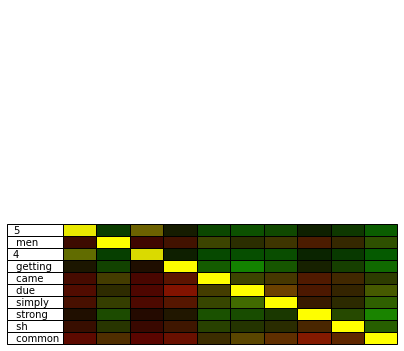

In [27]:
import matplotlib.pyplot as plt

num = 10
colors = []
for i in range(num):
    colors.append([])
    for j in range(num):
        #v1 = 30 * chosen_ausp[i,:]
        #v2 = 30 * chosen_ausp[j,:]
        v1 = 4 * ausp1[chosen_tokens[i],:]
        v2 = 4 * ausp1[chosen_tokens[j],:]
        combo = v1 + v2
        probs = embed_vector_to_probs(combo)
        r = probs[chosen_tokens[i]].item()
        g = probs[chosen_tokens[j]].item()
        b = 0
        colors[-1].append((r,g,b))
        
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.table(cellColours=colors, rowLabels=[decode(t) for t in chosen_tokens[:num]])
ax